In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Data loading

In [47]:
names = ['end_timestamp', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'label']

background = pd.read_csv("data/training/background_flows_cut.csv", header=None, names=names, nrows=5000)
blacklist = pd.read_csv("data/training/blacklist_flows_cut.csv", header=None, names=names, nrows=5000)
spam = pd.read_csv("data/training/spam_flows_cut.csv", header=None, names=names)
sshscan = pd.read_csv("data/training/sshscan_flows_cut.csv", header=None, names=names, nrows=5000)

df = pd.concat([background, blacklist, spam, sshscan], ignore_index=True)
df.head()

,end_timestamp,duration,src_ip,dst_ip,src_port,dst_port,protocol,flags,status,service_type,packets,bytes,label
0,2016-04-18 00:02:00,55.952,42.219.153.125,212.115.145.8,32004,55116,TCP,.A....,0,0,29544,1197024,background
1,2016-04-18 00:02:01,13.148,143.72.8.137,42.219.156.231,53,56415,UDP,.A....,0,0,2,250,background
2,2016-04-18 00:02:01,13.160,143.72.8.137,42.219.156.231,53,42993,UDP,.A....,0,0,2,256,background
3,2016-04-18 00:02:02,12.704,143.72.8.137,42.219.156.231,53,49453,UDP,.A....,0,0,2,256,background
4,2016-04-18 00:02:02,13.196,143.72.8.137,42.219.156.231,53,49998,UDP,.A....,0,0,2,256,background


## Dataset Observations

In [48]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 15041

Sumber of Nan values: 0

Column number: 13

Column names:
['end_timestamp', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'label']

Column types:


end_timestamp     object
duration         float64
src_ip            object
dst_ip            object
src_port           int64
dst_port           int64
protocol          object
flags             object
status             int64
service_type       int64
packets            int64
bytes              int64
label             object
dtype: object

#### Control of flows

In [49]:
print(f"Number of background exchanges : {len(df[df.label == 'background'])}")
print(f"Number of attack: {len(df[df.label != 'background'])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 5000
Number of attack: 10041
Number of blacklisted IP attack: 5000
Number of ssh scan attack: 5000
Number of spam attack: 41


#### Numeric columns

In [50]:
numeric_df = df.select_dtypes(include=[np.int64, np.float64])
numeric_df.describe()

,duration,src_port,dst_port,status,service_type,packets,bytes
count,15041.000000,15041.000000,15041.000000,15041.0,15041.000000,15041.000000,1.504100e+04
mean,3.285029,22705.262549,22542.117346,0.0,5.881790,33.697959,2.366716e+04
std,7.673002,24071.037155,23915.280690,0.0,15.193315,423.370008,3.606047e+05
min,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,3.200000e+01
25%,0.000000,53.000000,53.000000,0.0,0.000000,1.000000,1.310000e+02
50%,1.028000,4135.000000,1829.000000,0.0,0.000000,6.000000,8.030000e+02
75%,4.232000,47182.000000,46795.000000,0.0,8.000000,13.000000,1.890000e+03
max,313.104000,65493.000000,65458.000000,0.0,200.000000,29544.000000,1.765682e+07


## Dataset Visualisation

/home/leiyks/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


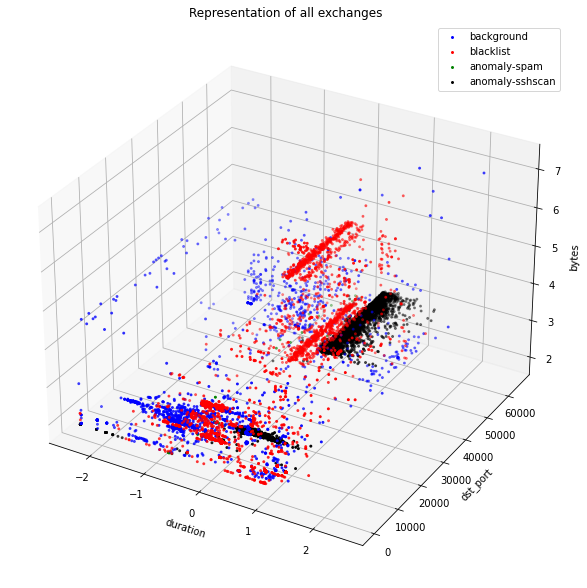

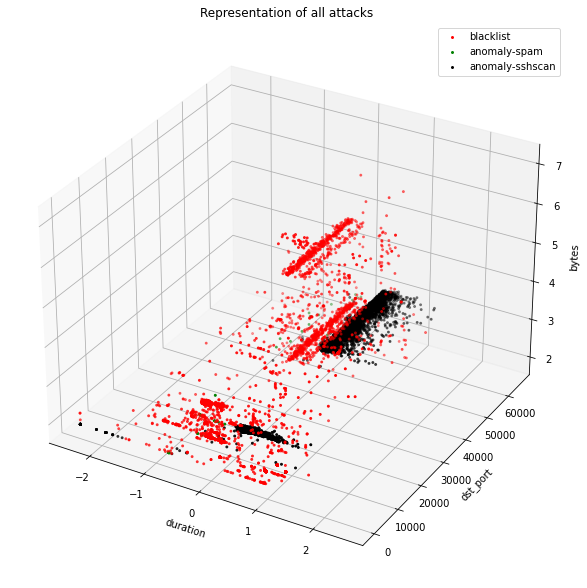

In [51]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    color = {
        'background': 'blue',
        'blacklist': 'red',
        'anomaly-spam': 'green',
        'anomaly-sshscan': 'black'
    }

    for label in df.label.unique():
        df_label = df[df.label == label]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x), y, np.log10(z), color=color[label], label=label, marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.label != 'background'], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')

## Data Cleaning

In [52]:
one_hot_encoded_df = pd.get_dummies(df.copy())
one_hot_encoded_df.head()
display(one_hot_encoded_df.head())
print(one_hot_encoded_df.isna().sum().any())

,duration,src_port,dst_port,status,service_type,packets,bytes,end_timestamp_2016-04-18 00:02:00,end_timestamp_2016-04-18 00:02:01,end_timestamp_2016-04-18 00:02:02,...,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,label_anomaly-spam,label_anomaly-sshscan,label_background,label_blacklist
0,55.952,32004,55116,0,0,29544,1197024,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.148,53,56415,0,0,2,250,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,13.160,53,42993,0,0,2,256,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,12.704,53,49453,0,0,2,256,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,13.196,53,49998,0,0,2,256,0,0,1,...,0,0,0,0,0,0,0,0,1,0


False


## Outlier detection

#### Isolation Forests

In [53]:
outlier_ratio = 0.03

classifier = IsolationForest(contamination=outlier_ratio)
classifier.fit(one_hot_encoded_df.values)
y_pred = classifier.predict(one_hot_encoded_df.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]

fraudulent_outliers = df_outliers[df_outliers.label_background == 0][df_outliers.if_outliers == True]
print(f'{len(fraudulent_outliers)} outliers are labelled as attack.')
fraudulent_outliers.head()

225 outliers are labelled as attack.


/tmp/ipykernel_57043/38902215.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fraudulent_outliers = df_outliers[df_outliers.label_background == 0][df_outliers.if_outliers == True]


,duration,src_port,dst_port,status,service_type,packets,bytes,end_timestamp_2016-04-18 00:02:00,end_timestamp_2016-04-18 00:02:01,end_timestamp_2016-04-18 00:02:02,...,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,label_anomaly-spam,label_anomaly-sshscan,label_background,label_blacklist,if_outliers
5016,0.116,65442,80,0,0,2,80,0,0,0,...,0,0,0,0,0,0,0,0,1,True
5023,0.372,53,50389,0,72,2,117,0,0,0,...,0,0,0,0,0,0,0,0,1,True
5170,0.004,47544,80,0,40,2,104,0,0,0,...,0,0,0,0,0,0,0,0,1,True
5180,20.996,40193,25,0,0,4,240,0,0,0,...,0,0,0,0,0,0,0,0,1,True
5199,0.072,61453,443,0,0,2,80,0,0,0,...,0,0,0,0,0,0,0,0,1,True


/home/leiyks/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


451


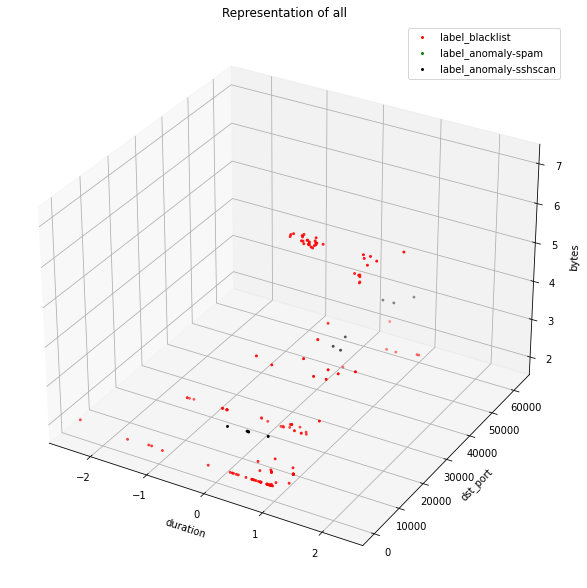

In [54]:
def show3D_flow_exchanges_outliers_only(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    color = {
        'label_blacklist': 'red',
        'label_anomaly-spam': 'green',
        'label_anomaly-sshscan': 'black'
    }

    for label in color.keys():
        df_label = df[df[label] == 1]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x), y, np.log10(z), color=color[label], label=label, marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges_outliers_only(df_outliers[df_outliers.if_outliers == True], 'duration', 'dst_port', 'bytes', 'Representation of all ')